In [1]:
import pandas as pd

# Charger les fichiers CSV
train_features = pd.read_csv("train_features.csv")
train_labels = pd.read_csv("train_labels.csv")
test_features = pd.read_csv("test_features.csv")
submission_format = pd.read_csv("submission_format.csv")


In [2]:
print("Train Features:\n")
train_features.head()


Train Features:



,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
2,aape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,6.2 or 3 times a month,2.4 or more times a week,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
3,aard,1. 50–59,"1. 100,000+",3. Widowed,1.0,3. 7–9 years,1. 1 or 2,0.0,4. Fair,0.0,...,1.very important,4.Once a week,9.Never,1.Yes,NaN,NaN,NaN,NaN,No 2,Concrete 2
4,ablr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,3.2 or 3 times a week,3.2 or 3 times a week,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"


In [3]:
print("Train Labels:\n")
train_labels.head(10)

Train Labels:



,uid,year,composite_score
0,aace,2021,175
1,aanz,2021,206
2,aape,2016,161
3,aape,2021,144
4,aard,2021,104
5,ablr,2021,183
6,abme,2021,106
7,abrn,2021,144
8,acet,2021,152
9,acgx,2021,144


In [4]:
print("train features shape:", train_features.shape)
print("train labels shape:", train_labels.shape)

train features shape: (3276, 184)
train labels shape: (4343, 3)


In [5]:
# Étape 1 : Vérifier et utiliser 'uid' comme index
if 'uid' in train_features.columns:
    train_features = train_features.set_index('uid')

if 'uid' in train_labels.columns:
    train_labels = train_labels.set_index('uid')

# Étape 2 : Identifier les indices communs
common_indices = train_features.index.intersection(train_labels.index)
print(f"Nombre d'indices communs : {len(common_indices)}")

# Étape 3 : Synchroniser les deux bases de données en éliminant les autres indices
train_features = train_features.loc[common_indices].copy()
train_labels = train_labels.loc[common_indices].copy()

# Étape 4 : Vérifier et traiter les NaN uniquement pour éviter des suppressions globales
print("Avant traitement des NaN :")
print(f"NaN dans train_features : {train_features.isnull().sum().sum()}")
print(f"NaN dans train_labels : {train_labels.isnull().sum().sum()}")

train_features = train_features.fillna(train_features.median(numeric_only=True))
train_labels = train_labels.fillna(train_labels.mode().iloc[0])  # Remplace par le mode pour les catégoriques

print("Après traitement des NaN :")
print(f"NaN dans train_features : {train_features.isnull().sum().sum()}")
print(f"NaN dans train_labels : {train_labels.isnull().sum().sum()}")

# Étape 5 : Vérifier si des indices dupliqués existent et les éliminer si nécessaire
train_features = train_features[~train_features.index.duplicated(keep='first')]
train_labels = train_labels[~train_labels.index.duplicated(keep='first')]

# Étape 6 : Vérifier les nouvelles dimensions et les indices
print("Après synchronisation et nettoyage :")
print("train_features shape :", train_features.shape)
print("train_labels shape :", train_labels.shape)
print("Indices train_features (premiers) :", train_features.index[:5])
print("Indices train_labels (premiers) :", train_labels.index[:5])


Nombre d'indices communs : 3276
Avant traitement des NaN :
NaN dans train_features : 135341
NaN dans train_labels : 0
Après traitement des NaN :
NaN dans train_features : 38649
NaN dans train_labels : 0
Après synchronisation et nettoyage :
train_features shape : (3276, 183)
train_labels shape : (3276, 2)
Indices train_features (premiers) : Index(['aace', 'aanz', 'aape', 'aard', 'ablr'], dtype='object', name='uid')
Indices train_labels (premiers) : Index(['aace', 'aanz', 'aape', 'aard', 'ablr'], dtype='object', name='uid')


In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import re

def preprocess_data(features, labels=None):
    # Exclure la colonne 'uid' avant toute transformation
    if 'uid' in features.columns:
        features = features.set_index('uid')

    # Identifier les colonnes numériques et catégorielles
    numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = features.select_dtypes(exclude=['float64', 'int64']).columns

    # Identifier et traiter les colonnes problématiques (non numériques)
    for col in features.columns:
        if features[col].dtype == 'object':  # Si une colonne est de type 'object'
            features[col] = features[col].astype(str).apply(lambda x: re.search(r'\d+', x).group(0) if re.search(r'\d+', x) else np.nan)
            features[col] = pd.to_numeric(features[col], errors='coerce')  # Convertir en numérique

    # Mise à jour des colonnes numériques et catégorielles après transformation
    numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = features.select_dtypes(exclude=['float64', 'int64']).columns

    # Gestion des colonnes complètement vides
    features = features.dropna(axis=1, how='all')

    # Gestion des valeurs manquantes
    for col in numeric_cols:  # Colonnes numériques
        if features[col].isnull().any():
            features[col] = features[col].fillna(features[col].median())  # Remplacer les NaN par la médiane

    for col in categorical_cols:  # Colonnes catégorielles
        if features[col].isnull().any():
            mode_value = features[col].mode()[0]  # Calculer le mode
            features[col] = features[col].fillna(mode_value)  # Remplacer les NaN par le mode

    # Vérifier la présence de NaN ou Inf
    if features.isnull().any().any():
        print("Attention : Des NaN subsistent après le nettoyage.")
    if (features == float('inf')).any().any():
        print("Attention : Des valeurs infinies subsistent après le nettoyage.")

    # Normalisation des colonnes numériques uniquement
    scaler = StandardScaler()
    features[numeric_cols] = scaler.fit_transform(features[numeric_cols])

    # Si des labels sont fournis, les séparer
    if labels is not None:
        labels = labels["composite_score"]
        return features, labels

    return features

# Prétraiter les données
X_train, y_train = preprocess_data(train_features, train_labels)
X_test = preprocess_data(test_features)

print("Prétraitement terminé :")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)


Prétraitement terminé :
X_train shape: (3276, 183)
y_train shape: (3276,)
X_test shape: (819, 183)


In [7]:
# Vérifier la cohérence entre X_train et y_train
if len(X_train) != len(y_train):
    print(f"Incohérence détectée : X_train a {len(X_train)} échantillons, mais y_train en a {len(y_train)}.")
    # Trouver les indices communs si nécessaire
    common_indices = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_indices]
    y_train = y_train.loc[common_indices]
    print(f"Après correction : X_train a {len(X_train)} échantillons et y_train en a {len(y_train)}.")

# Diviser les données en ensemble d'entraînement et de validation
from sklearn.model_selection import train_test_split

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Taille des ensembles :")
print("Entraînement :", X_train_split.shape, y_train_split.shape)
print("Validation :", X_val.shape, y_val.shape)

Taille des ensembles :
Entraînement : (2620, 183) (2620,)
Validation : (656, 183) (656,)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten
from tensorflow.keras import regularizers


# Définir le modèle
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train_split.shape[1],)),
    Dropout(0.1),
    Dense(4, activation='relu'),
    Dropout(0.1),
    Dense(1)
])
# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Afficher le résumé du modèle
model.summary()


2025-01-13 18:55:37.100217: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 18:55:37.116202: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 18:55:37.150688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736790937.200887 2015144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736790937.216092 2015144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,513 (5.91 KB)

 Trainable params: 1,513 (5.91 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Définir le callback pour arrêter tôt si la validation ne s'améliore plus
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

# Évaluer les performances finales sur l'ensemble de validation
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss}, Validation MAE: {mae}")


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 27185.9629 - mae: 153.2128 - val_loss: 29738.5117 - val_mae: 160.2903
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26571.2715 - mae: 151.1944 - val_loss: 29250.5000 - val_mae: 158.7088
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 25730.1758 - mae: 148.4731 - val_loss: 27956.4941 - val_mae: 154.5773
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24999.7090 - mae: 145.1655 - val_loss: 25104.9785 - val_mae: 145.4880
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21248.5000 - mae: 131.8997 - val_loss: 20436.7461 - val_mae: 129.9957
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17509.1875 - mae: 118.3329 - val_loss: 13350.8018 - val_mae: 103.2830
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10394.3730 - mae: 87.7231 - val_loss: 7739.5693 - val_mae: 75.1446
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7025.8726 - mae: 68.8381 - val_loss: 5248.4702 - 

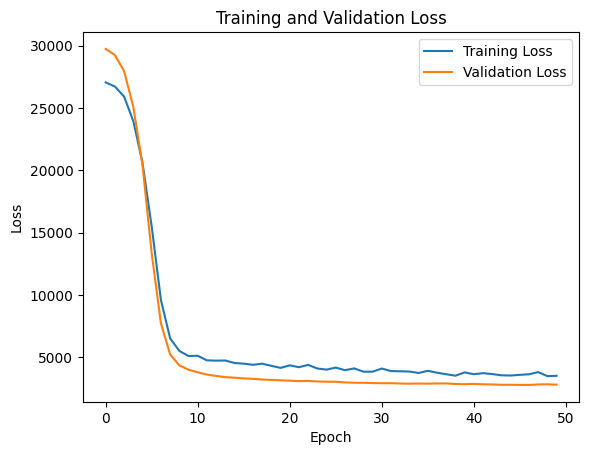

In [10]:
# Plot Loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [11]:
import pandas as pd
import numpy as np

# Charger les fichiers nécessaires
submission_format = pd.read_csv("submission_format.csv")
test_features = pd.read_csv("test_features.csv")

# Assurez-vous que les types de colonnes 'uid' soient compatibles
submission_format["uid"] = submission_format["uid"].astype(str)
test_features["uid"] = test_features["uid"].astype(str)

# Supposons que 'y_pred' est le tableau des prédictions généré par votre modèle
# Exemple fictif : générer des prédictions aléatoires (à remplacer par votre vrai `model.predict`)
y_pred = np.random.rand(len(test_features)) * 300  # Ajustez ce facteur si nécessaire

# Créer un DataFrame pour les prédictions
predictions_df = pd.DataFrame({
    "uid": test_features["uid"],
    "composite_score": y_pred
})

# Fusionner les prédictions avec le fichier submission_format
submission = submission_format.merge(predictions_df, on="uid", how="left")

# Résoudre le problème des colonnes multiples
if "composite_score_x" in submission.columns and "composite_score_y" in submission.columns:
    submission["composite_score"] = submission["composite_score_y"]
    submission = submission.drop(columns=["composite_score_x", "composite_score_y"])
elif "composite_score_y" in submission.columns:
    submission["composite_score"] = submission["composite_score_y"]
    submission = submission.drop(columns=["composite_score_y"])
elif "composite_score_x" in submission.columns:
    submission["composite_score"] = submission["composite_score_x"]
    submission = submission.drop(columns=["composite_score_x"])
else:
    print("Erreur : La colonne 'composite_score' est absente après la fusion.")
    print("Colonnes actuelles :", submission.columns)
    exit()

# Réorganiser les colonnes pour correspondre au format attendu
submission = submission[["uid", "year", "composite_score"]]

# Sauvegarder le fichier final
submission.to_csv("submission.csv", index=False)

print("Fichier 'submission.csv' généré avec succès.")


Fichier 'submission.csv' généré avec succès.
